# Customer Lifetime Value Estimation with BG-NBD and Gamma-Gamma

## Business Problem

FLO wants to set a roadmap for sales and marketing activities. In order for the company to make a medium-long-term plan, it is necessary to estimate the potential value that existing customers will provide to the company in the future.

### Dataset Story

The dataset consists of the information obtained from the past shopping behavior of customers who made their last purchases from Flo as OmniChannel (both online and offline shopper) between 2020 and 2021.

**master_id :** Unique customer number

**order_channel:** Which channel of the shopping platform is used (Android, ios, Desktop, Mobile)

**last_order_channel:** The channel where the most recent purchase was made

**first_order_date:** Date of the customer's first purchase

**last_order_date:** Customer's last purchase date

**last_order_date_online:** The date of the last purchase made by the customer on the online platform

**last_order_date_offline:**The date of the last purchase made by the customer on the offline platform

**order_num_total_ever_online:** The total number of purchases made by the customer on the online platform

**order_num_total_ever_offline:** Total number of purchases made by the customer offline

**customer_value_total_ever_offline:** Total fee paid by the customer for offline purchases

**customer_value_total_ever_online:** The total fee paid by the customer for their online shopping

**interested_in_categories_12:** List of categories the customer has shopped in the last 12 months




In [1]:
!pip install lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 811.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.5 MB/s eta 0:00:00


In [2]:
#Necessary libraries are imported.
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler

In [3]:
df_ = pd.read_csv("../input/flo-data/flo_data_20k.csv")

In [4]:
df = df_.copy()

## Data Overview

In [5]:
#The first 5 rows of the dataset were looked at.
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR]


In [6]:
#The last 5 rows of the dataset were viewed.
df.tail()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,Android App,Offline,2019-09-21,2020-07-05,2020-06-05,2020-07-05,1.0000,2.0000,289.9800,111.9800,"[ERKEK, AKTIFSPOR]"
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,Desktop,Desktop,2020-03-01,2020-12-22,2020-12-22,2020-03-01,1.0000,1.0000,150.4800,239.9900,[AKTIFSPOR]
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,Ios App,Ios App,2019-09-11,2021-05-24,2021-05-24,2019-09-11,2.0000,1.0000,139.9800,492.9600,[AKTIFSPOR]
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,Android App,Android App,2019-03-27,2021-02-13,2021-02-13,2021-01-08,1.0000,5.0000,711.7900,297.9800,"[ERKEK, AKTIFSPOR]"
19944,740998d2-b1f7-11e9-89fa-000d3a38a36f,Android App,Android App,2019-09-03,2020-06-06,2020-06-06,2019-09-03,1.0000,1.0000,39.9900,221.9800,"[KADIN, AKTIFSPOR]"


In [7]:
#Variable types and numbers of the data set were examined.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

In [8]:
#It was checked for missing data in the dataset.
df.isnull().sum()

master_id                            0
order_channel                        0
last_order_channel                   0
first_order_date                     0
last_order_date                      0
last_order_date_online               0
last_order_date_offline              0
order_num_total_ever_online          0
order_num_total_ever_offline         0
customer_value_total_ever_offline    0
customer_value_total_ever_online     0
interested_in_categories_12          0
dtype: int64

In [9]:
#The statistical properties of the columns of the data set containing numeric data were checked.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0000,3.1109,4.2256,1.0000,1.0000,2.0000,4.0000,200.0000
order_num_total_ever_offline,19945.0000,1.9139,2.0629,1.0000,1.0000,1.0000,2.0000,109.0000
customer_value_total_ever_offline,19945.0000,253.9226,301.5329,10.0000,99.9900,179.9800,319.9700,18119.1400
customer_value_total_ever_online,19945.0000,497.3217,832.6019,12.9900,149.9800,286.4600,578.4400,45220.1300


In [10]:
#The number of unique values for each variable in the dataset was looked at.
df.nunique()

master_id                            19945
order_channel                            4
last_order_channel                       5
first_order_date                      2465
last_order_date                        366
last_order_date_online                1743
last_order_date_offline                738
order_num_total_ever_online             57
order_num_total_ever_offline            32
customer_value_total_ever_offline     6097
customer_value_total_ever_online     11292
interested_in_categories_12             32
dtype: int64

## Data Manipulation

In [11]:
##The data types of the date variables are changed with datetime module to be able to use them in date calculations.
convert_date = df.columns[df.columns.str.contains("date")]

df[convert_date] = df[convert_date].apply(pd.to_datetime)
df.dtypes

master_id                                    object
order_channel                                object
last_order_channel                           object
first_order_date                     datetime64[ns]
last_order_date                      datetime64[ns]
last_order_date_online               datetime64[ns]
last_order_date_offline              datetime64[ns]
order_num_total_ever_online                 float64
order_num_total_ever_offline                float64
customer_value_total_ever_offline           float64
customer_value_total_ever_online            float64
interested_in_categories_12                  object
dtype: object

In [12]:
#the names of the numeric columns were put into a list.
columns = ["order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline","customer_value_total_ever_online"]

<AxesSubplot:>

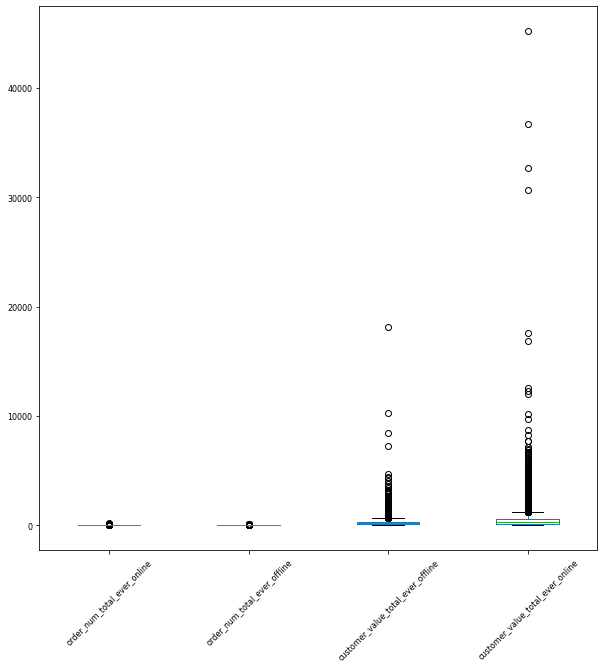

In [13]:
#Checked for outliers.
df.boxplot(column= columns,grid=False, rot=45,figsize = (10,10), fontsize=8) 

In [14]:
 """
    Defines upper and lower limits to investigate outlying values. 
    The limits are defined by adding and subtracting 1.5 interquantile 
    range values respectively to 3rd quartile and 1st quartile.
    
    Parameters
    ----------
    dataframe : dataframe
        The dataframe to be used.
    variable : dataframe variable
        The variable whose limits are intended to be calculated.
    
    Returns
    -------
    low_limit: Lower limit for outlier check.
    upper_limit: Upper limit for outlier check.   
    """
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [15]:
"""
       Replaces the outlying values lower than low_limit and higher than
       up_limit variables which are defined by outlier_threshold function.

       Parameters
       ----------
       dataframe : dataframe
           The dataframe to be used.
       variable : dataframe variable
           The variable whose limits are intended to be implemented.
       """
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit,0)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit,0)

In [16]:
"""
     Checks if the dataframe variable has any values higher 
     than upper limit and lower than lower limit

       Parameters
       ----------
       dataframe : dataframe
           The dataframe to be used.
       col_name : dataframe variable
           The variable whose values are compared to limits.
"""
def check_outlier(dataframe, col_name):
    low_limit , up_limit = outlier_thresholds(dataframe, col_name)
    
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        
        print(f"{col_name}: Lower limit = {low_limit}, Upper limit = {up_limit}")
        return True
    else:
        
        print(f"{col_name}: Lower limit = {low_limit}, Upper limit = {up_limit}")
        return False

In [17]:
#outliers were suppressed.
for col in columns:
    print(f"Any outliers: {check_outlier(df,col)}")
    replace_with_thresholds(df, col)

order_num_total_ever_online: Lower limit = -27.5, Upper limit = 48.5
Any outliers: True
order_num_total_ever_offline: Lower limit = -8.0, Upper limit = 16.0
Any outliers: True
customer_value_total_ever_offline: Lower limit = -1779.9452000000003, Upper limit = 3019.8820000000005
Any outliers: True
customer_value_total_ever_online: Lower limit = -4615.7406000000055, Upper limit = 7799.541000000008
Any outliers: True


In [18]:
"""
Omnichannel means that customers shop from both online and offline platforms. 
New variables were created for the total number of purchases and spending of each customer.
"""
df["total_order_num"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["total_price"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,total_order_num,total_price
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN],5.0000,939.3700
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.0000,2013.5500
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]",5.0000,585.3200
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]",2.0000,121.9700
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR],2.0000,209.9800


In [19]:
#For time analysis purposes, an analysis date is defined which is 2 days later than the last transaction.
print(df["last_order_date"].max())
today_date=dt.datetime(2021,6,1)

2021-05-30 00:00:00


In [20]:
#CLTV dataframe is formed by customer ids, weekly recency, weekly tenure, frequency and average monetary.
cltv = pd.DataFrame()
cltv["customer_id"] = df["master_id"]
cltv["recency"] = (df["last_order_date"]- df["first_order_date"])/ dt.timedelta(weeks=1)
cltv["T"] = ((today_date - df["first_order_date"]).dt.days)/7
cltv["frequency"] = df["total_order_num"]
cltv["monetary"] = df["total_price"] / df["total_order_num"]
cltv.head()

,customer_id,recency,T,frequency,monetary
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900


# CLTV Prediction

## BG-NBD 

In [21]:
#BG/NBD model is prepared and parameters are obtained
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv['frequency'],
        cltv['recency'],
        cltv['T'])

<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 76.17, b: 0.00, r: 3.66>

In [22]:
#Expected sale values of customers are calculated for following 3 month interval.
cltv["exp_sales_3_month"] = bgf.predict(12,
                                       cltv['frequency'],
                                       cltv['recency'],
                                       cltv['T'])

In [23]:
#Expected sale values of customers are calculated for following 6 month interval.
cltv["exp_sales_6_month"] = bgf.predict(24,
                                       cltv['frequency'],
                                       cltv['recency'],
                                       cltv['T'])

In [24]:
cltv.head()

,customer_id,recency,T,frequency,monetary,exp_sales_3_month,exp_sales_6_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,1.9479
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,1.9663
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,1.3412
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,1.4008
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.7921


In [25]:
"""
If we examine the data below, let's compare the customers in rows 1 and 4. 1. because 
customer's exp_sales value is bigger. The expected number of sales (1 month) was high, 
since the amount of products the customer shopped for was quite high and he did not do 
his shopping at a very distant date. When we look at the 4th customer, the frequency value
is lower, but the monetary value is almost 1.5 times higher, we should know that the 
monetary value has no effect on the calculation of the expected number of purchases. 
In addition, since this customer has not shopped for a longer period of time, 
he ranks lower than the 1st customer.
"""
cltv.sort_values(by = "exp_sales_6_month", ascending =False).head()

,customer_id,recency,T,frequency,monetary,exp_sales_3_month,exp_sales_6_month
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,67.2857,52.0000,166.2246,4.6561,9.3123
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.7143,40.0000,29.0000,165.2976,3.3740,6.7479
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28.8571,33.2857,25.0000,97.4396,3.1424,6.2848
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.5714,58.7143,31.0000,228.5300,3.0838,6.1676
14373,f00ad516-c4f4-11ea-98f7-000d3a38a36f,38.0000,46.4286,27.0000,141.3548,3.0013,6.0026


## Gamma - Gamma

In [26]:
#Gamma-Gamma model is fitted and average values of customers are calculated.
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv['frequency'],
        cltv['monetary'])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.15, q: 0.47, v: 4.08>

In [27]:
cltv["exp_average_value"] = ggf.conditional_expected_average_profit(cltv['frequency'],
                                                                       cltv['monetary'])
cltv.head()

,customer_id,recency,T,frequency,monetary,exp_sales_3_month,exp_sales_6_month,exp_average_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,1.9479,193.6327
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,1.9663,96.6650
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,1.3412,120.9676
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,1.4008,67.3201
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.7921,114.3251


In [28]:
#CLTV values for 6 months are calculated.
cltv_gamma = ggf.customer_lifetime_value(bgf,
                                   cltv['frequency'],
                                   cltv['recency'],
                                   cltv['T'],
                                   cltv['monetary'],
                                   time=6, 
                                   freq="W", 
                                   discount_rate=0.01)
cltv["cltv"] = cltv_gamma


In [29]:
"""
Let's examine the top person out of these 20 people. We look at our top customer, 
frequency value of 4 is seriously low, we see that there is a 35-day customer with a 
transaction like (T-recency)x7. We can connect its low frequency with this. When we 
ook at the Monetary value, we see it as the highest value among the first 20 people.
And the fact that this value is high, in a way, carried it to the top among cltv values. 
From here we can say that the height of the monetary value is in a positive correlation
with the customer life time value.

"""
cltv.sort_values("cltv",ascending=False)[:20]

,customer_id,recency,T,frequency,monetary,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.8571,7.8571,4.0000,1401.8000,1.0944,2.1888,1449.0605,3327.7770
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.1429,13.1429,11.0000,758.0855,1.9701,3.9402,767.3606,3172.3944
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.7143,101.0000,7.0000,1106.4671,0.7222,1.4445,1127.6115,1708.9821
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.2857,74.5714,16.0000,501.8737,1.5653,3.1306,506.1667,1662.6135
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,67.2857,52.0000,166.2246,4.6561,9.3123,166.7123,1628.8874
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.4286,34.4286,8.0000,601.2262,1.2655,2.5309,611.4926,1623.8127
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.2857,9.4286,2.0000,862.6900,0.7939,1.5878,923.6800,1538.8559
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.7143,13.0000,17.0000,259.8653,2.7807,5.5614,262.0729,1529.2280
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.5714,58.7143,31.0000,228.5300,3.0838,6.1676,229.6069,1485.8192
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.8571,15.5714,3.0000,743.5867,0.8716,1.7431,778.0504,1422.9997


## Segment Operation

In [30]:
#Customers are segmented to 4 groups according to their 6 month CLTV values
cltv["cltv_segment"] = pd.qcut(cltv["cltv"], 4, labels=["D", "C", "B", "A"])
cltv.head()

,customer_id,recency,T,frequency,monetary,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv,cltv_segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,1.9479,193.6327,395.7332,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,1.9663,96.6650,199.4307,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,1.3412,120.9676,170.2242,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,1.4008,67.3201,98.9455,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.7921,114.3251,95.0117,D


In [31]:
#The mean values of recency, frequency and monetary are observed for each segment.
cltv.groupby("cltv_segment").agg(["mean","count"])

recency              T       frequency       monetary       exp_sales_3_month       exp_sales_6_month       exp_average_value           cltv      
                 mean count     mean count      mean count     mean count              mean count              mean count              mean count     mean count
cltv_segment                                                                                                                                                    
D            139.0002  4987 162.1832  4987    3.7688  4987  93.1516  4987            0.4089  4987            0.8178  4987           98.6911  4987  80.3405  4987
C             92.6295  4986 112.8183  4986    4.4047  4986 125.7885  4986            0.5254  4986            1.0509  4986          132.2506  4986 138.3115  4986
B             81.9884  4986 100.3265  4986    5.0927  4986 160.6366  4986            0.6011  4986            1.2022  4986          168.0006  4986 199.5328  4986
A             67.4271  4986  82.5497  4986    6.6466  4986 228.8311  4986            0.7730  4986            1.5461  4986          238.0240  4986 362.3155  4986